## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels'),
 PosixPath('/home/jupyter/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

In [ ]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/images/0016E5_08067.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0016E5_02280.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0006R0_f02400.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_01380_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_00750_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/Seq05VD_f01710_P.png')]

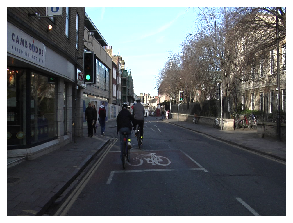

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [10]:
img.size

torch.Size([720, 960])

In [11]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

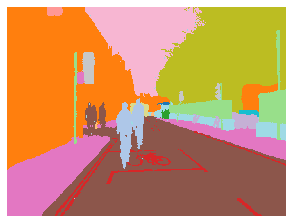

In [12]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [19]:
print(img_f.stem, img_f.suffix)

('0016E5_08067', '.png')

In [22]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [23]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [24]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 16270MB of GPU RAM free


In [26]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [27]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

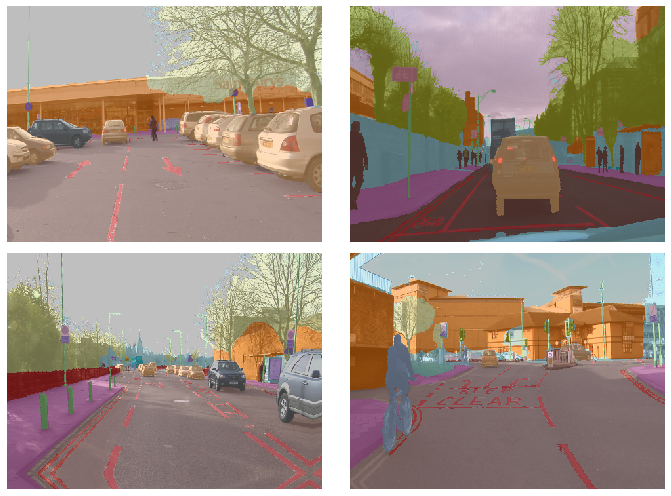

In [28]:
data.show_batch(2, figsize=(10,7))

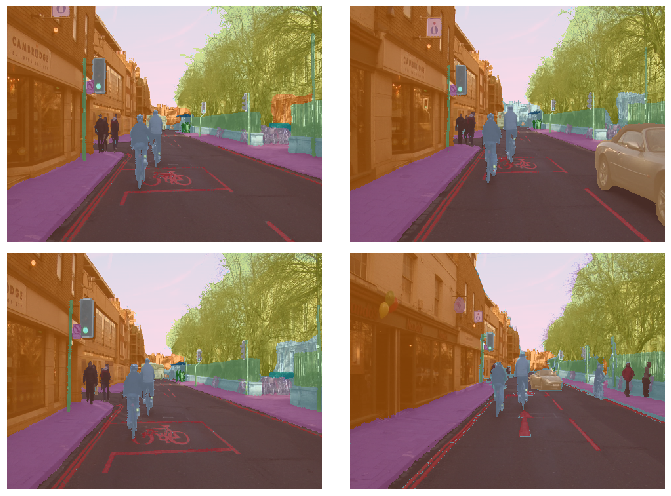

In [29]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [30]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [31]:
metrics=acc_camvid
# metrics=accuracy

In [32]:
wd=1e-2

In [33]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


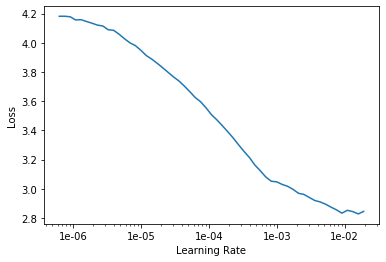

In [34]:
lr_find(learn)
learn.recorder.plot()

In [36]:
lr=3e-3

In [37]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.344224,0.941231,0.776225,00:52
1,0.875540,0.641703,0.829668,00:49
2,0.723683,0.645211,0.838658,00:49
3,0.689324,0.600659,0.843662,00:49
4,0.634973,0.549953,0.858116,00:49
5,0.601484,0.467696,0.869633,00:49
6,0.572202,0.483485,0.881923,00:49
7,0.539533,0.408365,0.896995,00:49
8,0.526127,0.431433,0.881304,00:49
9,0.459311,0.349650,0.902762,00:49


In [38]:
learn.save('stage-1')

In [39]:
learn.load('stage-1');

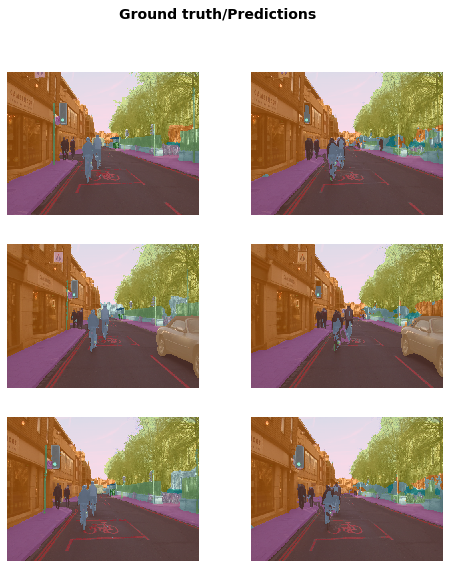

In [40]:
learn.show_results(rows=3, figsize=(8,9))

In [41]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


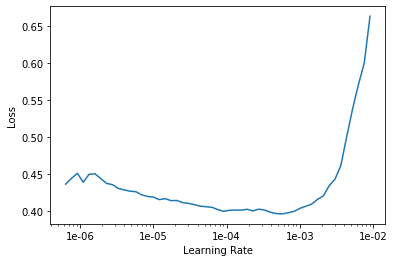

In [42]:
learn.lr_find()
learn.recorder.plot()

In [46]:
lr

0.003

In [44]:
lrs = slice(lr/400,lr/4)
lrs

slice(7.5e-06, 0.00075, None)

In [47]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.386564,0.324457,0.908631,00:51
1,0.383073,0.312575,0.914529,00:51
2,0.369023,0.306411,0.915370,00:51
3,0.351048,0.300635,0.915632,00:51
4,0.344391,0.302010,0.916426,00:51
5,0.331722,0.282697,0.919386,00:51
6,0.331210,0.283312,0.917094,00:52
7,0.323598,0.265632,0.925947,00:51
8,0.310303,0.290354,0.921804,00:51
9,0.296018,0.280678,0.921487,00:51


In [49]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [51]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=4
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this object has been destroyed
using bs=4, have 15609MB of GPU RAM free


In [52]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [53]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [54]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


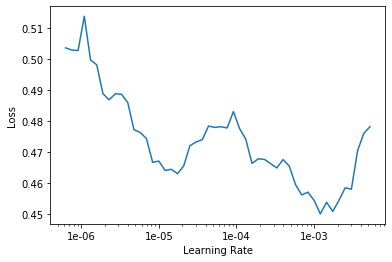

In [55]:
lr_find(learn)
learn.recorder.plot()

In [57]:
lr=1e-3

In [58]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.363425,0.335074,0.906302,03:19
1,0.331990,0.316765,0.911718,03:17
2,0.317776,0.293584,0.921034,03:16
3,0.320859,0.323350,0.924734,03:17
4,0.308110,0.277087,0.924552,03:17
5,0.316188,0.307479,0.918997,03:16
6,0.311255,0.291238,0.922512,03:16
7,0.288400,0.331922,0.922609,03:16
8,0.269861,0.285401,0.925564,03:17
9,0.231223,0.247985,0.932453,03:16


In [62]:
learn.save('stage-1-big')

In [63]:
learn.load('stage-1-big');

In [64]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


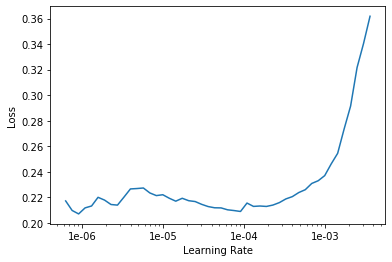

In [65]:
learn.lr_find()
learn.recorder.plot()

In [68]:
lrs = slice(8e-6, 8e-5)
lrs

slice(8e-06, 8e-05, None)

In [69]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.219986,0.248370,0.932172,03:23
1,0.216518,0.246229,0.933735,03:23
2,0.215716,0.249896,0.933094,03:23
3,0.203355,0.256343,0.933491,03:23
4,0.199687,0.236438,0.936491,03:23
5,0.198445,0.249632,0.934628,03:23
6,0.190415,0.247100,0.936016,03:23
7,0.186408,0.255043,0.935001,03:23
8,0.184050,0.258533,0.934281,03:23
9,0.184054,0.258537,0.934366,03:23


In [70]:
learn.save('stage-2-big')

In [71]:
learn.load('stage-2-big');

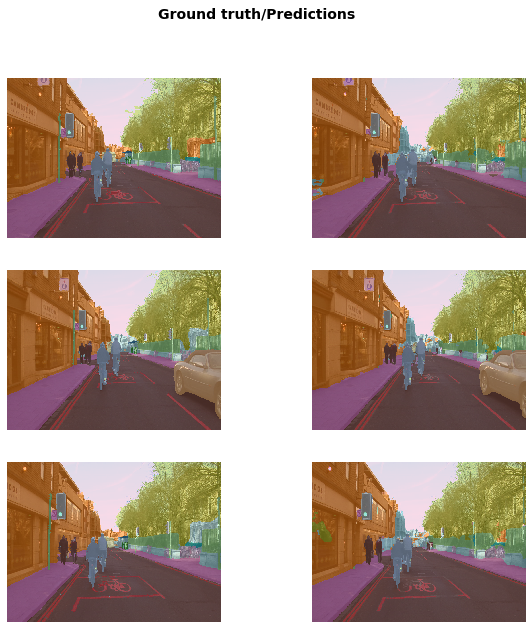

In [72]:
learn.show_results(rows=3, figsize=(10,10))

## fin